# Sentiment Analysis and Prediction in Python



In [1]:
%%capture
!pip install wordcloud


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load data as a DataFrame
df = pd.read_csv("movie_reviews.csv")

# Preview the data
df.sample(3)

,text,label
3213,This is a superb film and was immediately put ...,1
2605,"I never thought I see a movie worse than ""Lisa...",0
3971,I first saw this movie at a premiere-party in ...,1


In [3]:
df.shape

(4000, 2)

## Explore our data


In [4]:
# Inspect the data types and non-null rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [5]:
# Check the value counts of the sentiment label
df["label"].value_counts(normalize=True)

0    0.5085
1    0.4915
Name: label, dtype: float64

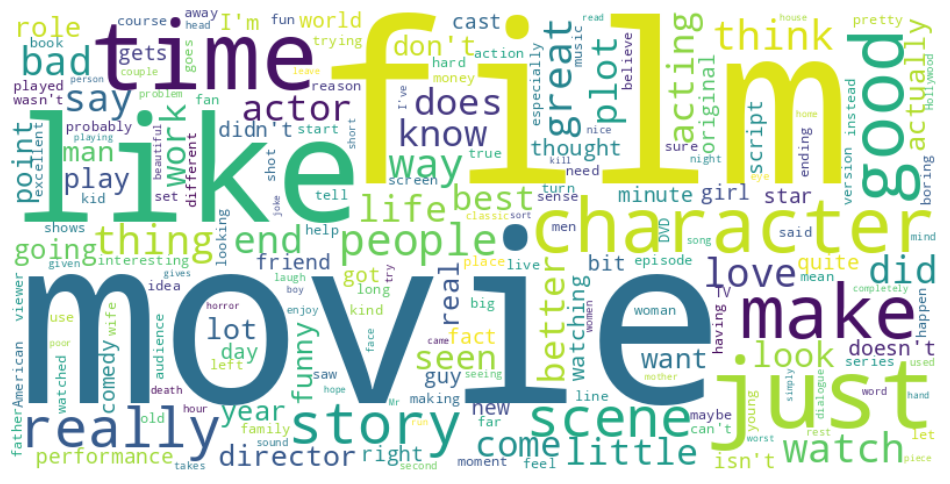

In [6]:
# Concatenate the text review data
reviews = " ".join(df["text"])

# Create the word cloud image
word_cloud = WordCloud(background_color="white",
                       stopwords=ENGLISH_STOP_WORDS,
                       width=800,
                       height=400
                      )

# Generate the word cloud using the review data
word_cloud.generate(reviews)

# Display the word cloud
plt.rcParams["figure.figsize"] = (12, 8)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

## Pre-processing the review text
To pre-process the text, we will use the term frequency-inverse document frequency, or TfIdf. TfIdf is a way of calculating the importance of words in a collection of different sets of text (or documents).
TfIdf has the advantages of:

- Highlighting words that are common within a document but not across documents.
- Returning low scores for words common across all reviews (e.g., movie in movie reviews).
- Penalizing frequent words so we don't need to worry about stop words as much.

Fortunately, Scikit-Learn has a [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class that can convert text data into a set of TfIdf features.

In [14]:
# Specify the word pattern
pattern = r"[a-zA-Z]+"

# Build the vectorizer and fit to the text data
vect = TfidfVectorizer(
	token_pattern=pattern,
    stop_words=ENGLISH_STOP_WORDS,
    ngram_range=(1, 2),
    max_features=500
)

vect.fit(df["text"])

# Create sparse matrix from the vectorizer
tokenized_features = vect.transform(df["text"])

# Create a DataFrame of the new features
features = pd.DataFrame(data=tokenized_features.toarray(), columns=vect.get_feature_names_out())

features.columns


Index(['able', 'absolutely', 'act', 'acting', 'action', 'actor', 'actors',
       'actress', 'actually', 'add',
       ...
       'wouldn t', 'writer', 'writing', 'written', 'wrong', 'year', 'year old',
       'years', 'yes', 'young'],
      dtype='object', length=500)

In [15]:
# Generate a number of different length metrics based on the text
df["char_count"] = df["text"].str.count(r"\S")
df["word_count"] = df["text"].str.count(pattern)
df["avg_word_length"] = df["char_count"] / df["word_count"]

# Preview our new columns
df.sample(3)

,text,label,char_count,word_count,avg_word_length
2917,If you want to enjoy the money you would spend...,0,409,101,4.049505
1901,I found it highly interesting that the film ac...,1,403,84,4.797619
3690,I have seen this film only the one time about ...,1,312,76,4.105263


## Fitting a model and evaluating its performance

In [10]:
# Define X and y
X = pd.concat([features, df.loc[:, "char_count":]], axis=1)
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
	X,
    y,
    test_size=0.25,
    random_state=42
)

# Train a random forest classifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Predict the labels
y_pred = rf.predict(X_test)

# Print classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       523
           1       0.76      0.80      0.78       477

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.79      1000



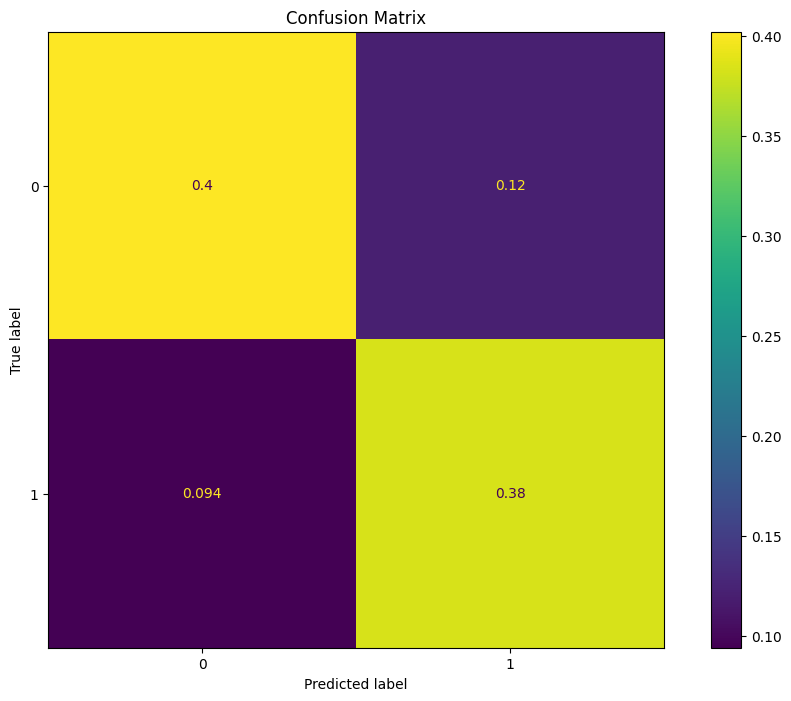

In [11]:
# Print a confusion matrix for the model
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix")
plt.show()

# Testing saving

In [12]:
# Create a DataFrame of the features and their importances
pd.DataFrame(
	{"feature": X.columns, "importance": rf.feature_importances_}
).sort_values(by="importance", ascending=False)

,feature,importance
27,bad,0.045045
487,worst,0.031163
174,great,0.021562
415,t,0.016111
25,awful,0.015166
...,...,...
420,talent,0.000416
482,words,0.000411
160,game,0.000385
17,aren,0.000374
